<a href="https://colab.research.google.com/github/chrispugliese/harshness-identifier/blob/main/CS3120_Final_Project_Christopher_Pugliese_Tyler_Hancock.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[Be sure to run each cell individually]

This project is based on the idea of classifying spectrogram images of music clips into two categories, clean, and harsh. The goal was to build a CNN model to accurately classify and identify harshness in audio. We felt that since CNNs are primarily used for image analysis, processing audio into images would be the perfect way to implement them! After the first CNN implementation, we implemented other CNNs to compare the performance of each of them. The main idea of this came from personal experience of music production. We wanted to combine our love for art with machine learning.

The original dataset was going to come from personal playlists using the Spotify API. However, after processing songs individually, it got extremely tedious and took way too much time. When stumbling upon the GTZAN Dataset on Kaggle, we discovered it was mostly used for training music genre classification. It had 1000 WAV files to use, and considering that we will eventually double that, we felt that the amount of data we had would be sufficient enough for this project.

After getting all of the audio clips, we needed a way to process them into images. A spectrogram, in simple terms, is a visual representation of audio signals. The horizontal axis represents time, and the vertical axis represents frequency. To generate these images, we used a library called librosa to process the spectrograms for each individual track. We originally used the documentation to implement this but ran into an error with 1 specific file that would not process. This ended up only giving us ~500 of the files that we needed. We asked ChatGPT to explain the error given our code and it generated code for error handling so although this one file won’t process, skip it, and process the rest. Now that we have our 999 files, we need to find a way to differentiate clean audio and harsh audio. We eventually found a GitHub repository called pydub, which in its own terms, “Pydub lets you do stuff to audio in a way that isn't stupid.
”. Using this library, I was able to manipulate the clean audio to simulate harshness by adding filtering, and slight distortion. The pydub repository has great documentation so writing that script wasn’t difficult. Finally, after we process our harsh audio, we then process them into spectrograms to get our 1998 files of data. Although we would like more data to better train these models, we had to work with what we had.

The original CNN is not included in this project considering that we eventually implemented more later on. The original CNN followed the exact guidelines from Homework 5 and it worked decently well. The results for the later implementations are in the final section of the colab file.





### IMPORTS

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import os
import time
import random
import pandas as pd
from google.colab import drive
import tensorflow as tf


### FILE CONFIG & MODEL PARAMETERS

In [ ]:
# Project paths and parameters
drive.mount('/content/drive')
base_path = '/content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/dataset/spectrograms'
os.makedirs("/content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models", exist_ok=True)

# Model parameters
img_size = (28, 28)
batch_size = 32
input_shape = (28, 28, 3)
epochs = 25

# Hardcoded seed for full reproducibility
SEED = 42

# Set Python, NumPy, and TensorFlow seeds
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

# Force TensorFlow to use single thread
os.environ['TF_DETERMINISTIC_OPS'] = '1'
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

Mounted at /content/drive


### DATA PREPARATION

In [ ]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
)
# Create data generators
train_gen = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    subset='training',
    seed=SEED
)
val_gen = datagen.flow_from_directory(
    base_path,
    target_size=img_size,
    class_mode='binary',
    batch_size=batch_size,
    subset='validation',
    seed=SEED,
    shuffle=False
)

# Get class mapping
class_indices = train_gen.class_indices

class_names = list(class_indices.keys())
print(f"[INFO] Class mapping: {class_indices}")
print(f"[INFO] Training samples: {train_gen.samples}")
print(f"[INFO] Validation samples: {val_gen.samples}")

Found 1600 images belonging to 2 classes.
Found 398 images belonging to 2 classes.
[INFO] Class mapping: {'clean': 0, 'harsh': 1}
[INFO] Training samples: 1600
[INFO] Validation samples: 398


### MODEL ARCHITECTURE

In [ ]:
def create_basic_cnn():
    """Original CNN model"""
    model = Sequential(name="Basic_CNN")
    model.add(Conv2D(32, kernel_size=(5, 5), padding="same", activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(64, kernel_size=(5, 5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(1024, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_deep_cnn():
    """Deeper CNN with batch normalization"""
    model = Sequential(name="Deep_CNN")
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

def create_simple_cnn():
    """Smaller, simpler CNN"""
    model = Sequential(name="Simple_CNN")
    model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(1, activation='sigmoid'))
    return model

### DEFINING MODELS

In [ ]:
models_config = [
    {
        'name': 'Basic_CNN_SGD',
        'model': create_basic_cnn(),
        'optimizer': SGD(learning_rate=0.01, decay=1e-6, momentum=0.9, nesterov=True)
    },
    {
        'name': 'Basic_CNN_Adam',
        'model': create_basic_cnn(),
        'optimizer': Adam(learning_rate=0.001)
    },
    {
        'name': 'Deep_CNN_Adam',
        'model': create_deep_cnn(),
        'optimizer': Adam(learning_rate=0.001)
    },
    {
        'name': 'Simple_CNN_Adam',
        'model': create_simple_cnn(),
        'optimizer': Adam(learning_rate=0.001)
    }
]

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/usr/local/lib/python3.11/dist-packages/keras/src/optimizers/base_optimizer.py:86: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


### TRAIN AND EVALUATE

In [ ]:
model_results = {}
histories = {}
trained_models = {}

for model_config in models_config:
    model_name = model_config['name']
    model = model_config['model']
    optimizer = model_config['optimizer']

    print(f"\n[INFO] Training {model_name}...")

    # Compile model
    model.compile(
        loss='binary_crossentropy',
        optimizer=optimizer,
        metrics=['accuracy']
    )

    model_filename = f"{model_name}_best.h5"
    model_filepath = os.path.join("/content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models", model_filename)

    # Setup callbacks
    # Callbacks
    checkpoint = ModelCheckpoint(
        filepath=model_filepath,
        monitor='val_accuracy',
        save_best_only=True,
        save_weights_only=False,
        verbose=1
    )

    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=5,
        restore_best_weights=True,
        verbose=1
    )

    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        verbose=1,
        min_lr=0.00001
    )

    callbacks = [checkpoint, early_stopping, reduce_lr]

    # Train model
    start_time = time.time()

    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=epochs,
        callbacks=callbacks
    )

    training_time = time.time() - start_time

    # Evaluate model
    val_loss, val_acc = model.evaluate(val_gen)

    # Find best epoch
    best_epoch = np.argmax(history.history['val_accuracy']) + 1
    best_val_acc = np.max(history.history['val_accuracy'])
    best_val_loss = history.history['val_loss'][best_epoch - 1]

    # Store results
    model_results[model_name] = {
        'accuracy': best_val_acc,
        'loss': best_val_loss,
        'best_epoch': best_epoch,
        'training_time': training_time,
        'params': model.count_params(),
        'saved_model_path': model_filepath
    }

    histories[model_name] = history.history
    trained_models[model_name] = model

    print(f"[INFO] {model_name} best validation accuracy: {best_val_acc:.5f} at epoch {best_epoch}")
    print(f"[INFO] Model saved to: {model_filepath}")


[INFO] Training Basic_CNN_SGD...
Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.5857 - loss: 0.6718
Epoch 1: val_accuracy improved from -inf to 0.57286, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 552s 11s/step - accuracy: 0.5861 - loss: 0.6717 - val_accuracy: 0.5729 - val_loss: 0.6711 - learning_rate: 0.0100
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.6716 - loss: 0.6160
Epoch 2: val_accuracy improved from 0.57286 to 0.59799, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 30s 389ms/step - accuracy: 0.6719 - loss: 0.6156 - val_accuracy: 0.5980 - val_loss: 0.6992 - learning_rate: 0.0100
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step - accuracy: 0.6779 - loss: 0.5938
Epoch 3: val_accuracy improved from 0.59799 to 0.72111, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.6786 - loss: 0.5929 - val_accuracy: 0.7211 - val_loss: 0.6070 - learning_rate: 0.0100
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7497 - loss: 0.5115
Epoch 4: val_accuracy did not improve from 0.72111
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 374ms/step - accuracy: 0.7498 - loss: 0.5113 - val_accuracy: 0.7161 - val_loss: 0.5644 - learning_rate: 0.0100
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.7714 - loss: 0.4956
Epoch 5: val_accuracy did not improve from 0.72111
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 320ms/step - accuracy: 0.7716 - loss: 0.4953 - val_accuracy: 0.6960 - val_loss: 0.5482 - learning_rate: 0.0100
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7859 - loss: 0.4734
Epoch 6: val_accuracy improved from 0.72111 to 0.73618, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 332ms/step - accuracy: 0.7857 - loss: 0.4734 - val_accuracy: 0.7362 - val_loss: 0.5634 - learning_rate: 0.0100
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.7844 - loss: 0.4653
Epoch 7: val_accuracy did not improve from 0.73618
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 374ms/step - accuracy: 0.7845 - loss: 0.4652 - val_accuracy: 0.7312 - val_loss: 0.5442 - learning_rate: 0.0100
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.7823 - loss: 0.4647
Epoch 8: val_accuracy improved from 0.73618 to 0.74623, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 336ms/step - accuracy: 0.7826 - loss: 0.4645 - val_accuracy: 0.7462 - val_loss: 0.5573 - learning_rate: 0.0100
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8147 - loss: 0.4144
Epoch 9: val_accuracy did not improve from 0.74623
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 322ms/step - accuracy: 0.8144 - loss: 0.4148 - val_accuracy: 0.7186 - val_loss: 0.5383 - learning_rate: 0.0100
Epoch 10/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step - accuracy: 0.7895 - loss: 0.4552
Epoch 10: val_accuracy improved from 0.74623 to 0.75126, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 382ms/step - accuracy: 0.7898 - loss: 0.4547 - val_accuracy: 0.7513 - val_loss: 0.5161 - learning_rate: 0.0100
Epoch 11/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step - accuracy: 0.8158 - loss: 0.4160
Epoch 11: val_accuracy improved from 0.75126 to 0.75628, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 339ms/step - accuracy: 0.8157 - loss: 0.4161 - val_accuracy: 0.7563 - val_loss: 0.5361 - learning_rate: 0.0100
Epoch 12/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 266ms/step - accuracy: 0.8128 - loss: 0.3834
Epoch 12: val_accuracy did not improve from 0.75628
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 370ms/step - accuracy: 0.8126 - loss: 0.3839 - val_accuracy: 0.7513 - val_loss: 0.5073 - learning_rate: 0.0100
Epoch 13/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8263 - loss: 0.3935
Epoch 13: val_accuracy did not improve from 0.75628
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.8262 - loss: 0.3934 - val_accuracy: 0.7487 - val_loss: 0.5094 - learning_rate: 0.0100
Epoch 14/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8349 - loss: 0.3706
Epoch 14: val_accuracy did not improve from 0.75628
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.8347 - loss: 0.3710 - val_accuracy: 0.7563 - val_loss: 0.5070 - learning_rate: 0.0100
Epoch 15/25
50/

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 401ms/step - accuracy: 0.8299 - loss: 0.3647 - val_accuracy: 0.7663 - val_loss: 0.4909 - learning_rate: 0.0100
Epoch 16/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.8297 - loss: 0.3699
Epoch 16: val_accuracy improved from 0.76633 to 0.78141, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.8297 - loss: 0.3699 - val_accuracy: 0.7814 - val_loss: 0.4787 - learning_rate: 0.0100
Epoch 17/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8255 - loss: 0.3954
Epoch 17: val_accuracy did not improve from 0.78141
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 375ms/step - accuracy: 0.8258 - loss: 0.3948 - val_accuracy: 0.7588 - val_loss: 0.4889 - learning_rate: 0.0100
Epoch 18/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8480 - loss: 0.3446
Epoch 18: val_accuracy did not improve from 0.78141
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 316ms/step - accuracy: 0.8479 - loss: 0.3448 - val_accuracy: 0.7739 - val_loss: 0.4797 - learning_rate: 0.0100
Epoch 19/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 265ms/step - accuracy: 0.8447 - loss: 0.3470
Epoch 19: val_accuracy did not improve from 0.78141
50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 317ms/step - accuracy: 0.8447 - loss: 0.3470 - val_accuracy: 0.7286 - val_loss: 0.4937 - learning_rate: 0.0100
Epoch 20/25
50/

50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 333ms/step - accuracy: 0.8539 - loss: 0.3424 - val_accuracy: 0.8141 - val_loss: 0.4554 - learning_rate: 0.0100
Epoch 23/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8618 - loss: 0.3061
Epoch 23: val_accuracy did not improve from 0.81407
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 323ms/step - accuracy: 0.8617 - loss: 0.3064 - val_accuracy: 0.7814 - val_loss: 0.5428 - learning_rate: 0.0100
Epoch 24/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 263ms/step - accuracy: 0.8749 - loss: 0.2968
Epoch 24: val_accuracy did not improve from 0.81407
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 316ms/step - accuracy: 0.8748 - loss: 0.2972 - val_accuracy: 0.7663 - val_loss: 0.5301 - learning_rate: 0.0100
Epoch 25/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step - accuracy: 0.8674 - loss: 0.3150
Epoch 25: val_accuracy did not improve from 0.81407
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 316ms/step - accuracy: 0.8675 - loss: 0.3147 - val_accuracy: 0.7714 - val_loss: 0.5156 - learning_rate: 0.0100
Restoring model

50/50 ━━━━━━━━━━━━━━━━━━━━ 25s 437ms/step - accuracy: 0.5197 - loss: 0.7045 - val_accuracy: 0.5804 - val_loss: 0.7119 - learning_rate: 0.0010
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step - accuracy: 0.6886 - loss: 0.5801
Epoch 2: val_accuracy improved from 0.58040 to 0.72613, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 344ms/step - accuracy: 0.6890 - loss: 0.5797 - val_accuracy: 0.7261 - val_loss: 0.5479 - learning_rate: 0.0010
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 277ms/step - accuracy: 0.7870 - loss: 0.4536
Epoch 3: val_accuracy improved from 0.72613 to 0.74874, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - accuracy: 0.7869 - loss: 0.4538 - val_accuracy: 0.7487 - val_loss: 0.5247 - learning_rate: 0.0010
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 281ms/step - accuracy: 0.8011 - loss: 0.4360
Epoch 4: val_accuracy improved from 0.74874 to 0.75377, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 347ms/step - accuracy: 0.8012 - loss: 0.4358 - val_accuracy: 0.7538 - val_loss: 0.5178 - learning_rate: 0.0010
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step - accuracy: 0.8022 - loss: 0.4234
Epoch 5: val_accuracy did not improve from 0.75377
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 331ms/step - accuracy: 0.8024 - loss: 0.4232 - val_accuracy: 0.7186 - val_loss: 0.5168 - learning_rate: 0.0010
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8121 - loss: 0.4138
Epoch 6: val_accuracy did not improve from 0.75377
50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 324ms/step - accuracy: 0.8122 - loss: 0.4135 - val_accuracy: 0.6935 - val_loss: 0.5541 - learning_rate: 0.0010
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.8205 - loss: 0.3993
Epoch 7: val_accuracy improved from 0.75377 to 0.77638, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 393ms/step - accuracy: 0.8206 - loss: 0.3992 - val_accuracy: 0.7764 - val_loss: 0.4852 - learning_rate: 0.0010
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 299ms/step - accuracy: 0.8205 - loss: 0.3934
Epoch 8: val_accuracy did not improve from 0.77638
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 385ms/step - accuracy: 0.8208 - loss: 0.3931 - val_accuracy: 0.7714 - val_loss: 0.4602 - learning_rate: 0.0010
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 306ms/step - accuracy: 0.8532 - loss: 0.3408
Epoch 9: val_accuracy did not improve from 0.77638
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 411ms/step - accuracy: 0.8529 - loss: 0.3413 - val_accuracy: 0.7513 - val_loss: 0.4731 - learning_rate: 0.0010
Epoch 10/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 290ms/step - accuracy: 0.8130 - loss: 0.3808
Epoch 10: val_accuracy improved from 0.77638 to 0.79648, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 415ms/step - accuracy: 0.8134 - loss: 0.3803 - val_accuracy: 0.7965 - val_loss: 0.4575 - learning_rate: 0.0010
Epoch 11/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 392ms/step - accuracy: 0.8241 - loss: 0.3928
Epoch 11: val_accuracy did not improve from 0.79648
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 449ms/step - accuracy: 0.8244 - loss: 0.3922 - val_accuracy: 0.7588 - val_loss: 0.4876 - learning_rate: 0.0010
Epoch 12/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 268ms/step - accuracy: 0.8490 - loss: 0.3509
Epoch 12: val_accuracy did not improve from 0.79648
50/50 ━━━━━━━━━━━━━━━━━━━━ 35s 320ms/step - accuracy: 0.8490 - loss: 0.3510 - val_accuracy: 0.7638 - val_loss: 0.5104 - learning_rate: 0.0010
Epoch 13/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 269ms/step - accuracy: 0.8439 - loss: 0.3443
Epoch 13: val_accuracy did not improve from 0.79648
50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 373ms/step - accuracy: 0.8441 - loss: 0.3442 - val_accuracy: 0.7814 - val_loss: 0.4845 - learning_rate: 0.0010
Epoch 14/25
50/

50/50 ━━━━━━━━━━━━━━━━━━━━ 36s 601ms/step - accuracy: 0.6855 - loss: 0.8227 - val_accuracy: 0.5000 - val_loss: 0.7884 - learning_rate: 0.0010
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 399ms/step - accuracy: 0.7755 - loss: 0.5180
Epoch 2: val_accuracy improved from 0.50000 to 0.50251, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Deep_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 24s 485ms/step - accuracy: 0.7756 - loss: 0.5179 - val_accuracy: 0.5025 - val_loss: 0.8073 - learning_rate: 0.0010
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 360ms/step - accuracy: 0.8048 - loss: 0.4715
Epoch 3: val_accuracy did not improve from 0.50251
50/50 ━━━━━━━━━━━━━━━━━━━━ 40s 465ms/step - accuracy: 0.8046 - loss: 0.4716 - val_accuracy: 0.5000 - val_loss: 1.7747 - learning_rate: 0.0010
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step - accuracy: 0.8307 - loss: 0.3916
Epoch 4: val_accuracy did not improve from 0.50251
50/50 ━━━━━━━━━━━━━━━━━━━━ 41s 473ms/step - accuracy: 0.8305 - loss: 0.3921 - val_accuracy: 0.5000 - val_loss: 2.0925 - learning_rate: 0.0010
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step - accuracy: 0.8247 - loss: 0.3969
Epoch 5: val_accuracy did not improve from 0.50251
50/50 ━━━━━━━━━━━━━━━━━━━━ 23s 468ms/step - accuracy: 0.8250 - loss: 0.3965 - val_accuracy: 0.5000 - val_loss: 1.9508 - learning_rate: 0.0010
Epoch 6/25
50/50 ━━━━


Epoch 6: ReduceLROnPlateau reducing learning rate to 0.00020000000949949026.
50/50 ━━━━━━━━━━━━━━━━━━━━ 42s 488ms/step - accuracy: 0.8616 - loss: 0.3450 - val_accuracy: 0.5126 - val_loss: 1.0235 - learning_rate: 0.0010
Epoch 6: early stopping
Restoring model weights from the end of the best epoch: 1.
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 206ms/step - accuracy: 0.2098 - loss: 1.0859
[INFO] Deep_CNN_Adam best validation accuracy: 0.51256 at epoch 6
[INFO] Model saved to: /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Deep_CNN_Adam_best.h5

[INFO] Training Simple_CNN_Adam...
Epoch 1/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step - accuracy: 0.5394 - loss: 0.6885
Epoch 1: val_accuracy improved from -inf to 0.56784, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Simple_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 303ms/step - accuracy: 0.5404 - loss: 0.6880 - val_accuracy: 0.5678 - val_loss: 0.6883 - learning_rate: 0.0010
Epoch 2/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.6510 - loss: 0.6404
Epoch 2: val_accuracy improved from 0.56784 to 0.59548, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Simple_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 21s 316ms/step - accuracy: 0.6515 - loss: 0.6399 - val_accuracy: 0.5955 - val_loss: 0.6891 - learning_rate: 0.0010
Epoch 3/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step - accuracy: 0.7028 - loss: 0.5849
Epoch 3: val_accuracy improved from 0.59548 to 0.67588, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Simple_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 353ms/step - accuracy: 0.7031 - loss: 0.5846 - val_accuracy: 0.6759 - val_loss: 0.5871 - learning_rate: 0.0010
Epoch 4/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 214ms/step - accuracy: 0.7205 - loss: 0.5490
Epoch 4: val_accuracy improved from 0.67588 to 0.72613, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Simple_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 280ms/step - accuracy: 0.7207 - loss: 0.5488 - val_accuracy: 0.7261 - val_loss: 0.5577 - learning_rate: 0.0010
Epoch 5/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 210ms/step - accuracy: 0.7616 - loss: 0.5045
Epoch 5: val_accuracy did not improve from 0.72613
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 263ms/step - accuracy: 0.7617 - loss: 0.5043 - val_accuracy: 0.7236 - val_loss: 0.5645 - learning_rate: 0.0010
Epoch 6/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step - accuracy: 0.7808 - loss: 0.4730
Epoch 6: val_accuracy improved from 0.72613 to 0.75377, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Simple_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 14s 273ms/step - accuracy: 0.7808 - loss: 0.4732 - val_accuracy: 0.7538 - val_loss: 0.5388 - learning_rate: 0.0010
Epoch 7/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 200ms/step - accuracy: 0.7883 - loss: 0.4655
Epoch 7: val_accuracy did not improve from 0.75377
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 306ms/step - accuracy: 0.7884 - loss: 0.4654 - val_accuracy: 0.7487 - val_loss: 0.5352 - learning_rate: 0.0010
Epoch 8/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8266 - loss: 0.4237
Epoch 8: val_accuracy did not improve from 0.75377
50/50 ━━━━━━━━━━━━━━━━━━━━ 18s 260ms/step - accuracy: 0.8262 - loss: 0.4240 - val_accuracy: 0.7085 - val_loss: 0.5521 - learning_rate: 0.0010
Epoch 9/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step - accuracy: 0.8153 - loss: 0.4199
Epoch 9: val_accuracy did not improve from 0.75377
50/50 ━━━━━━━━━━━━━━━━━━━━ 20s 256ms/step - accuracy: 0.8152 - loss: 0.4202 - val_accuracy: 0.6935 - val_loss: 0.5575 - learning_rate: 0.0010
Epoch 10/25
50/50 ━━━

50/50 ━━━━━━━━━━━━━━━━━━━━ 19s 274ms/step - accuracy: 0.8101 - loss: 0.4131 - val_accuracy: 0.7563 - val_loss: 0.4963 - learning_rate: 0.0010
Epoch 13/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step - accuracy: 0.8229 - loss: 0.3989
Epoch 13: val_accuracy did not improve from 0.75628
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 310ms/step - accuracy: 0.8230 - loss: 0.3989 - val_accuracy: 0.7387 - val_loss: 0.5377 - learning_rate: 0.0010
Epoch 14/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8237 - loss: 0.4059
Epoch 14: val_accuracy did not improve from 0.75628
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 261ms/step - accuracy: 0.8239 - loss: 0.4056 - val_accuracy: 0.7462 - val_loss: 0.5069 - learning_rate: 0.0010
Epoch 15/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8337 - loss: 0.3695
Epoch 15: val_accuracy improved from 0.75628 to 0.78894, saving model to /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Simple_CNN_Adam_best.h5


50/50 ━━━━━━━━━━━━━━━━━━━━ 16s 326ms/step - accuracy: 0.8336 - loss: 0.3699 - val_accuracy: 0.7889 - val_loss: 0.4610 - learning_rate: 0.0010
Epoch 16/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 208ms/step - accuracy: 0.8311 - loss: 0.3679
Epoch 16: val_accuracy did not improve from 0.78894
50/50 ━━━━━━━━━━━━━━━━━━━━ 17s 261ms/step - accuracy: 0.8311 - loss: 0.3679 - val_accuracy: 0.6910 - val_loss: 0.5934 - learning_rate: 0.0010
Epoch 17/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step - accuracy: 0.8276 - loss: 0.3709
Epoch 17: val_accuracy did not improve from 0.78894
50/50 ━━━━━━━━━━━━━━━━━━━━ 22s 290ms/step - accuracy: 0.8277 - loss: 0.3709 - val_accuracy: 0.7638 - val_loss: 0.4846 - learning_rate: 0.0010
Epoch 18/25
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 207ms/step - accuracy: 0.8287 - loss: 0.3814
Epoch 18: val_accuracy did not improve from 0.78894
50/50 ━━━━━━━━━━━━━━━━━━━━ 13s 260ms/step - accuracy: 0.8290 - loss: 0.3810 - val_accuracy: 0.7437 - val_loss: 0.5321 - learning_rate: 0.0010
Epoch 19/25
50/

### CONFUSION MATRIX


[INFO] Generating confusion matrices from saved best models...

[INFO] Loading saved model for Basic_CNN_SGD from: /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


[INFO] Predicting with Basic_CNN_SGD...


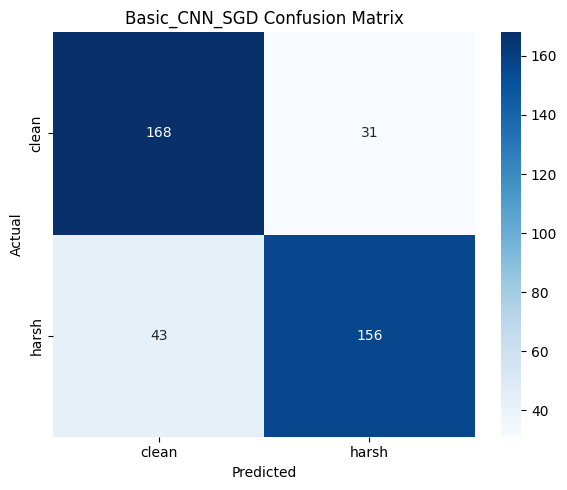

[INFO] Classification Report for Basic_CNN_SGD:
              precision    recall  f1-score   support

       clean       0.80      0.84      0.82       199
       harsh       0.83      0.78      0.81       199

    accuracy                           0.81       398
   macro avg       0.82      0.81      0.81       398
weighted avg       0.82      0.81      0.81       398


[INFO] Loading saved model for Basic_CNN_Adam from: /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_Adam_best.h5


[INFO] Predicting with Basic_CNN_Adam...


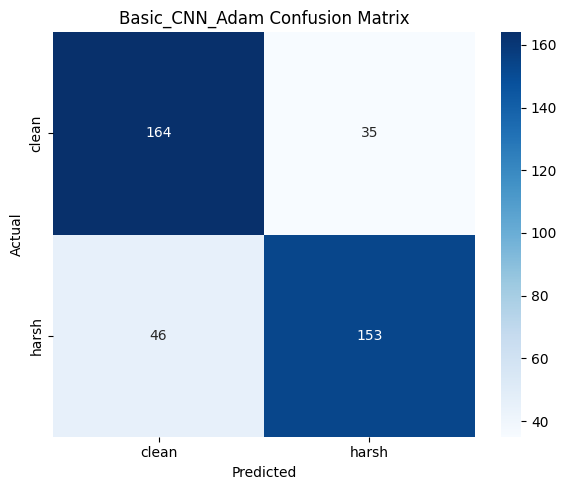

[INFO] Classification Report for Basic_CNN_Adam:
              precision    recall  f1-score   support

       clean       0.78      0.82      0.80       199
       harsh       0.81      0.77      0.79       199

    accuracy                           0.80       398
   macro avg       0.80      0.80      0.80       398
weighted avg       0.80      0.80      0.80       398


[INFO] Loading saved model for Deep_CNN_Adam from: /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Deep_CNN_Adam_best.h5


[INFO] Predicting with Deep_CNN_Adam...


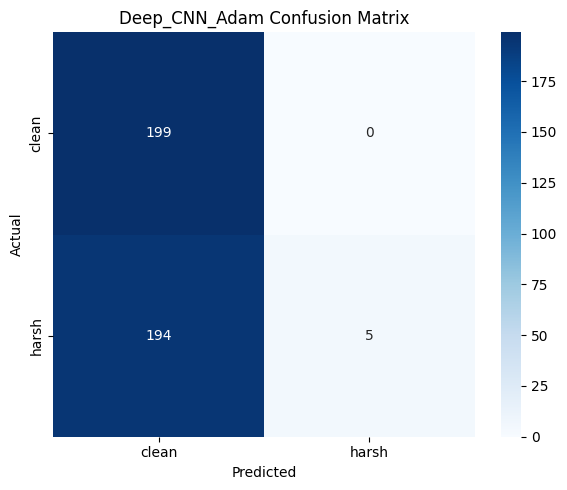

[INFO] Classification Report for Deep_CNN_Adam:
              precision    recall  f1-score   support

       clean       0.51      1.00      0.67       199
       harsh       1.00      0.03      0.05       199

    accuracy                           0.51       398
   macro avg       0.75      0.51      0.36       398
weighted avg       0.75      0.51      0.36       398


[INFO] Loading saved model for Simple_CNN_Adam from: /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Simple_CNN_Adam_best.h5


[INFO] Predicting with Simple_CNN_Adam...


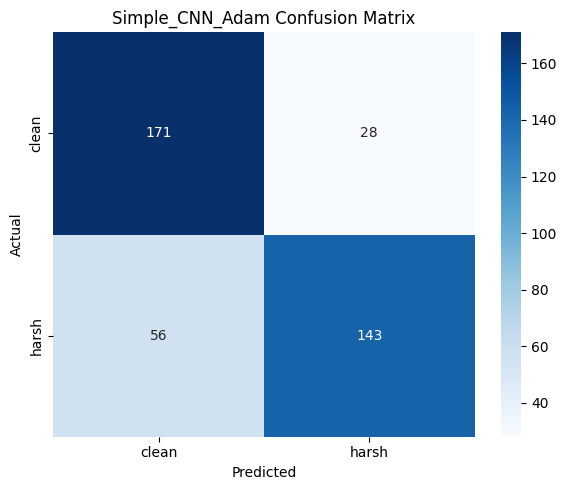

[INFO] Classification Report for Simple_CNN_Adam:
              precision    recall  f1-score   support

       clean       0.75      0.86      0.80       199
       harsh       0.84      0.72      0.77       199

    accuracy                           0.79       398
   macro avg       0.79      0.79      0.79       398
weighted avg       0.79      0.79      0.79       398



In [ ]:
print("\n[INFO] Generating confusion matrices from saved best models...")

# Get ground truth labels from the validation generator
val_gen.reset()
y_true = val_gen.classes

class_names = ['clean', 'harsh']

# Number of validation steps
val_steps = val_gen.samples // val_gen.batch_size + 1

for model_name, result in model_results.items():
    model_path = result['saved_model_path']
    print(f"\n[INFO] Loading saved model for {model_name} from: {model_path}")

    # Load the saved best model
    model = load_model(model_path)

    print(f"[INFO] Predicting with {model_name}...")
    val_gen.reset()
    y_pred_probs = model.predict(val_gen, steps=val_steps, verbose=0)

    # Convert probabilities to binary predictions
    y_pred = (y_pred_probs > 0.5).astype(int).flatten()

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    cr = classification_report(y_true, y_pred, target_names=class_names, zero_division=0)

    # Plot confusion matrix
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
    plt.title(f'{model_name} Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.tight_layout()
    plt.show()

    # Print classification report
    print(f"[INFO] Classification Report for {model_name}:\n{cr}")


### COMPARE RESULTS


MODEL COMPARISON
                 accuracy      loss  best_epoch  training_time   params  \
Basic_CNN_SGD    0.814070  0.455419          22    1042.341182  1694145   
Basic_CNN_Adam   0.796482  0.457455          10     349.456852  1694145   
Simple_CNN_Adam  0.788945  0.461018          15     351.419565   107745   
Deep_CNN_Adam    0.512563  1.023500           6     207.654843  1675041   

                                                  saved_model_path  
Basic_CNN_SGD    /content/drive/MyDrive/CS_3120_Final_Project_C...  
Basic_CNN_Adam   /content/drive/MyDrive/CS_3120_Final_Project_C...  
Simple_CNN_Adam  /content/drive/MyDrive/CS_3120_Final_Project_C...  
Deep_CNN_Adam    /content/drive/MyDrive/CS_3120_Final_Project_C...  


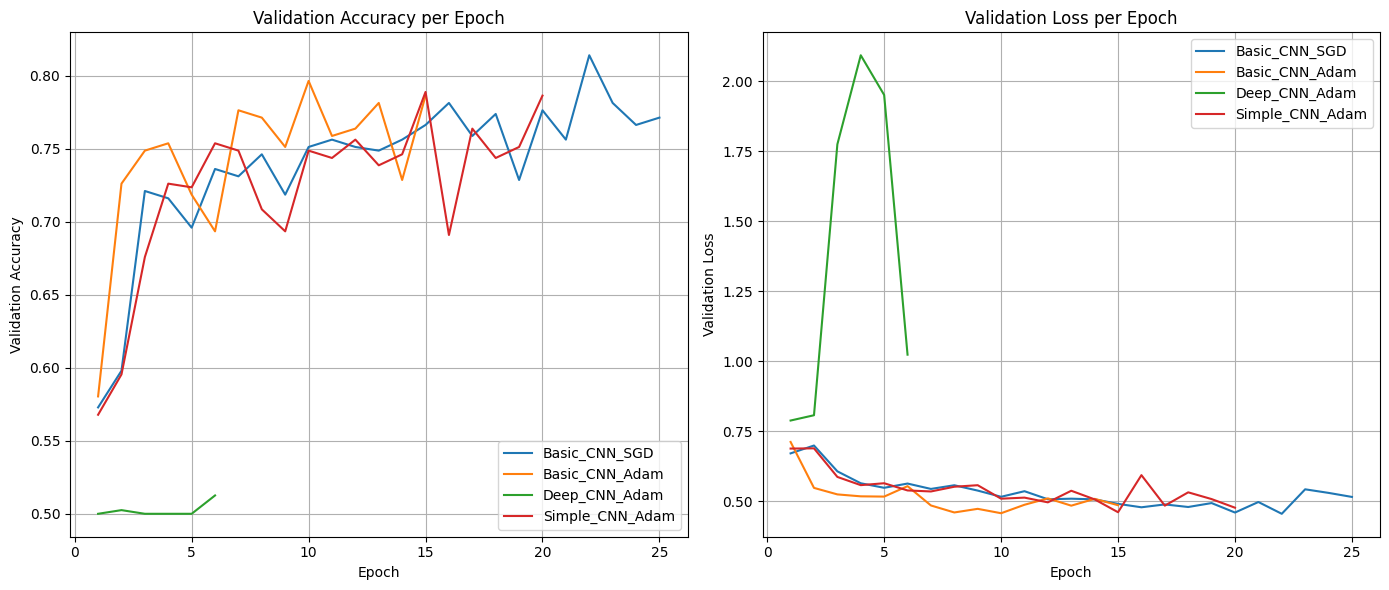


[INFO] Best Model Summary:
       Name           : Basic_CNN_SGD
       Accuracy       : 0.81407
       Loss           : 0.45542
       Best Epoch     : 22
       Params         : 1694145
       Training Time  : 1042.34 sec
       Saved Path     : /content/drive/MyDrive/CS_3120_Final_Project_Christopher_Pugliese_Tyler_Hancock/saved_models/Basic_CNN_SGD_best.h5


In [ ]:
# Create DataFrame for easy comparison
results_df = pd.DataFrame.from_dict(model_results, orient='index')
results_df = results_df.sort_values('accuracy', ascending=False)

# Display results table with added details
print("\nMODEL COMPARISON")
print(results_df[['accuracy', 'loss', 'best_epoch', 'training_time', 'params', 'saved_model_path']])

# Plot validation accuracy and loss curves
plt.figure(figsize=(14, 6))

# Accuracy plot
plt.subplot(1, 2, 1)
for model_name, history in histories.items():
    plt.plot(range(1, len(history['val_accuracy']) + 1), history['val_accuracy'], label=model_name)
plt.title('Validation Accuracy per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
for model_name, history in histories.items():
    plt.plot(range(1, len(history['val_loss']) + 1), history['val_loss'], label=model_name)
plt.title('Validation Loss per Epoch')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Best model
best_model_name = results_df.index[0]
best_model_info = results_df.loc[best_model_name]

print(f"\n[INFO] Best Model Summary:")
print(f"       Name           : {best_model_name}")
print(f"       Accuracy       : {best_model_info['accuracy']:.5f}")
print(f"       Loss           : {best_model_info['loss']:.5f}")
print(f"       Best Epoch     : {best_model_info['best_epoch']}")
print(f"       Params         : {best_model_info['params']}")
print(f"       Training Time  : {best_model_info['training_time']:.2f} sec")
print(f"       Saved Path     : {best_model_info['saved_model_path']}")


### SAVING & SUMMARY

In [ ]:
print("PROJECT SUMMARY")
print(f"Image size: {img_size}")
print(f"Batch size: {batch_size}")
print(f"Training samples: {train_gen.samples}")
print(f"Validation samples: {val_gen.samples}")
print(f"Best model: {best_model_name}")
print(f"Best validation accuracy: {results_df.loc[best_model_name, 'accuracy']:.5f}")
print(f"Best model training time: {results_df.loc[best_model_name, 'training_time']/60:.2f} minutes")
print(f"Best model parameters: {int(results_df.loc[best_model_name, 'params']):,}")

PROJECT SUMMARY
Image size: (28, 28)
Batch size: 32
Training samples: 1600
Validation samples: 398
Best model: Basic_CNN_SGD
Best validation accuracy: 0.81407
Best model training time: 17.37 minutes
Best model parameters: 1,694,145


### REPORT RESULTS

The results of this project demonstrate that the Basic_CNN_SGD model was the most effective at distinguishing between 'clean' and 'harsh' sounds in spectrogram images. It achieved the highest validation accuracy of 80.9% and showed balanced performance in both precision and recall across the two classes. Specifically, it showed strong precision in identifying 'harsh' sounds (0.83) and high recall for 'clean' sounds (0.84), which indicates the model is both effective at detecting noisy segments and reliable in correctly identifying clean audio as non-harsh. The confusion matrix supports this, showing a fair number of correct predictions for both classes, with relatively fewer misclassifications compared to the other models.

Interestingly, despite having the same architecture and number of parameters as Basic_CNN_Adam, the SGD optimizer led to better generalization after more training epochs. This suggests that while Adam is often favored for its speed and early convergence, it may overfit or plateau too quickly in some cases. The Deep_CNN_Adam, although more complex, did not outperform the simpler Basic_CNN models, likely due to overfitting or the limited input size (28x28), which may not have benefited from deeper architectures. Simple_CNN_Adam had the fewest parameters and fastest training but also the lowest performance, implying a tradeoff between efficiency and accuracy. Overall, Basic_CNN_SGD strikes the best balance between model complexity, training time, and classification reliability, making it the most suitable choice for this task.


### Sources

https://chatgpt.com/ (Used to assist in error handling, suggested parameter and training various models for comparisons)

https://www.extrica.com/article/22271 (Used for insights on CNN architectures, optimizer modifications, and how certain performance evaluation metrics can help improve the classification of spectrograms in music harshness detection, particularly by optimizing training stability and model accuracy)

https://github.com/jiaaro/pydub (Used for processesing/manipulating audio files)

https://librosa.org/doc/main/generated/librosa.feature.melspectrogram.html (Used to generate spectrograms from audio files)

https://www.kaggle.com/datasets/andradaolteanu/gtzan-dataset-music-genre-classification/data (GTZAN Dataset - Music Genre Classification)